In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import os
import json
from itertools import cycle
import torch
import torch.nn as nn
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchmetrics import Accuracy

from math import ceil

In [2]:
### Everything required for the model

basic_mb_params = [
    # Expand ratio, out channels, num layers, stride, kernel_size
    # k, c, t, s, k
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

alpha, beta = 1.2, 1.1

scale_values = {
    # (Phi, resolution, dropout)

    "b0": (0, 224, 0.2),
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

class ConvBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, groups=1):
        super(ConvBlock, self).__init__()

        self.block = nn.Sequential(
            
            nn.Conv2d(in_channels=in_channels,
                      out_channels=out_channels,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding,
                      groups=groups), # Specified to control how convolution is applied to input
                                      # If group = 1, kernel is applied to one channel only
                                      # if group = input channel, kernel is applied to one channel only

            nn.BatchNorm2d(out_channels),
            nn.SiLU()
        )
    
    def forward(self, x):
        return self.block(x)

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

class MBConv(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, ratio, reduction=2):
        super(MBConv, self).__init__()

        hidden_dim = in_channels * ratio
        self.expand = in_channels != hidden_dim

        # Squeeze and excitation block
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = ConvBlock(in_channels=in_channels,
                                         out_channels=hidden_dim,
                                         kernel_size=3,
                                         stride=1,
                                         padding=1)
        
        self.conv = nn.Sequential(
            ConvBlock(in_channels=hidden_dim,
                      out_channels=hidden_dim,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding,
                      groups=hidden_dim),

            SqueezeExcitation(in_channels=hidden_dim,
                              reduced_dim=reduced_dim),

            nn.Conv2d(in_channels=hidden_dim,
                      out_channels=out_channels,
                      kernel_size=1),

            nn.BatchNorm2d(out_channels)
        )

    def forward(self, inputs):
        if self.expand:
            x = self.expand_conv(inputs)
        else:
            x = inputs
            
        return self.conv(x)

class EfficientNet(nn.Module):
    def __init__(self, model_name, output, mb_params, dropout_newVal, linear_hiddenUnits_list=None):
        super(EfficientNet, self).__init__()
        
        phi, resolution, dropout = scale_values[model_name]

        if dropout_newVal != None:
            dropout = dropout_newVal

        if mb_params == None:
            mb_params = basic_mb_params

        self.mb_params = mb_params
        self.depth_factor, self.width_factor = alpha**phi, beta**phi
        self.last_channels = ceil(1280 * self.width_factor)
        self.avgpool= nn.AdaptiveAvgPool2d(1)
        self.feature_extractor()
        self.flatten = nn.Flatten()
        
        if linear_hiddenUnits_list == None:
            self.classifier = nn.Sequential(
                nn.Dropout(p=dropout),
                nn.Linear(in_features=self.last_channels,
                        out_features=output),
                nn.Softmax()
            )

        else:
            feed_forward_network_layers = [nn.Dropout(p=dropout)]
            feed_forward_network_layers.append(nn.Linear(self.last_channels, linear_hiddenUnits_list[0]))

            for i in range(0, len(linear_hiddenUnits_list)-1):
                feed_forward_network_layers.append(nn.Linear(linear_hiddenUnits_list[i], linear_hiddenUnits_list[i+1]))
                feed_forward_network_layers.append(nn.ReLU())

            feed_forward_network_layers.append(nn.Linear(linear_hiddenUnits_list[-1], output))
            feed_forward_network_layers.append(nn.ReLU())

            self.classifier = nn.Sequential(*feed_forward_network_layers)

    def feature_extractor(self):
        channels = int(32 * self.width_factor)
        features = [ConvBlock(3, channels, 3, stride=2, padding=1)] # Stem convolution layer
        in_channels = channels

        for k, c_o, repeat, s, n in self.mb_params:
            # For numeric stability, we multiply and divide by 4
            out_channels = 4 * ceil(int(c_o * self.width_factor) / 4)
            num_layers = ceil(repeat * self.depth_factor)

            for layer in range(num_layers):
                if layer == 0:
                  stride = s
                else:
                  stride = 1
                
                features.append(
                        MBConv(in_channels=in_channels,
                               out_channels=out_channels,
                               ratio=k,
                               stride=stride,
                               kernel_size=n,
                               padding=(n//2))
                )
                in_channels = out_channels

        features.append(
            ConvBlock(in_channels=in_channels,
                      out_channels=self.last_channels,
                      kernel_size=1,
                      stride=1,
                      padding=0)
        )
        self.extractor = nn.Sequential(*features)

    def forward(self, x):
        x = self.avgpool(self.extractor(x))
        
        return self.classifier(self.flatten(x))

In [13]:
def evaluate_model(model, device, history, dataloader, class_names, base_dir, output_dir_name="evaluation"):
    
    # Create output folder
    output_dir = os.path.join(base_dir, output_dir_name)

    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)

    model.eval()

    y_pred = []
    y_pred_probs = np.array([[0, 0, 0, 0, 0, 0, 0]])
    y_true = []

    with torch.inference_mode():
        
        for batch, (X, y) in enumerate(dataloader):

            X = X.to(device)
            y = y.to(device)

            # Predict class probabilities and labels
            batch_y_pred_probs = model(X)
            batch_y_pred = batch_y_pred_probs.argmax(dim=1)
            batch_y_true = y

            batch_y_pred = batch_y_pred.cpu()
            batch_y_true = batch_y_true.cpu()
            batch_y_pred_probs = batch_y_pred_probs.cpu()

            batch_y_pred = batch_y_pred.numpy()
            batch_y_true = batch_y_true.numpy()
            batch_y_pred_probs = batch_y_pred_probs.numpy()

            for i in range(0, len(batch_y_pred)):
                y_pred.append(batch_y_pred[i])
                y_true.append(batch_y_true[i])
            
            y_pred_probs = np.concat((y_pred_probs, batch_y_pred_probs), axis=0)

    np_y_pred = np.array(y_pred, dtype=np.int32)
    np_y_true = np.array(y_true, dtype=np.int32)

    ts_y_pred = torch.from_numpy(np_y_pred)
    ts_y_true = torch.from_numpy(np_y_true)

    y_pred_probs = y_pred_probs[1:, :]

    # 1. Accuracy

    accFn = Accuracy('multiclass', num_classes=7)

    acc = accFn(ts_y_pred, ts_y_true)
    acc *= 100

    print(f"\nAccuracy Score: {acc:.4f}%")

    # 2. Classification Report
    report = classification_report(np_y_true, np_y_pred, target_names=class_names)
    print("\nClassification Report:")
    print(report)

    # 3. Confusion Matrix
    # Raw Confusion Matrix
    cm = confusion_matrix(np_y_true, np_y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
    plt.show()

    # Normalized Confusion Matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Normalized Confusion Matrix")
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'normalized_confusion_matrix.png'))
    plt.show()

    # 4. Accuracy & Loss Curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['test_acc'], label='Test Accuracy')
    plt.title("Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['test_loss'], label='Test Loss')
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'training_curves.png'))
    plt.show()

    # 5. AUC Score (Macro)
    #Convert y_true values to binary one-hot encoded format
    y_true_bin = label_binarize(np_y_true, classes=list(range(len(class_names))))

    # Calculate the MACRO average of AUC using One-vs-Rest (OVR)
    auc_macro = roc_auc_score(y_true_bin, y_pred_probs, average='macro', multi_class='ovr')

    print(f"\nMacro AUC Score (OvR): {auc_macro:.4f}")

    # 6. ROC Curve Plot
    # Empty Dictionaries:
    # fpr = False Positive Rete
    # tpr = True Positive Rate
    # roc_auc = AUC Score for each class
    fpr, tpr, roc_auc = {}, {}, {}
    n_classes = len(class_names)
    colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2'])
    plt.figure(figsize=(10, 8))

    for i, color in zip(range(n_classes), colors):
        # Calculate fpr & tpr for each class
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])

        # Calculate AUC for each class
        roc_auc[i] = auc(fpr[i], tpr[i])

        plt.plot(fpr[i], tpr[i], lw=2, color=color,
                 label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

    #Labelling
    plt.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random Guess', alpha=0.7)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multiclass ROC Curve (OvR)\nMacro AUC = {auc_macro:.4f}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'roc_curve.png'))
    plt.show()

    # To write all Accuracy Sore, Classification Report & Macro AUC Score in outputs.txt
    with open(os.path.join(output_dir, 'outputs.txt'), 'w') as f:
        f.write(f"Accuracy Score: {acc:.4f}")
        f.write("\n\nClassification Report:\n")
        f.write(report)
        f.write(f"\nMacro AUC Score (OvR): {auc_macro:.4f}")

In [4]:
## Load model's previos settings

base_path = os.getcwd()
modelBase_path = os.path.join(base_path, "model_files")

model_name = "model_2"

modelSettings_path = os.path.join(modelBase_path, model_name, model_name+"_settings.json")

model_settings = None

with open(modelSettings_path, 'r') as json_file:
    model_settings = json.load(json_file)
    
    print(model_settings)
    print(type(model_settings))

{'model_name': 'model_2', 'model_type': 'b0', 'num_class': 7, 'epochs': 19, 'batch_size': 32, 'learning_rate': 0.0013, 'MBConv parameters': [[1, 16, 1, 1, 3], [6, 24, 2, 2, 3], [6, 40, 2, 2, 5], [6, 80, 3, 2, 3], [6, 112, 3, 1, 5], [6, 192, 4, 2, 5], [6, 320, 1, 1, 3]], 'dropout_rate': 0.32, 'optimizer': 'Adam', 'linear_layers_hidden_units': [1024, 512, 128, 32], 'loss_function': 'Cross Entropy Loss'}
<class 'dict'>


In [5]:
# Load entire model including layer and weights

modelFile_path = os.path.join(modelBase_path, model_name, model_name+"_weights.pth")

model = EfficientNet(model_name="b0",
                     output=7,
                     mb_params=basic_mb_params,
                     dropout_newVal=model_settings["dropout_rate"],
                     linear_hiddenUnits_list=model_settings["linear_layers_hidden_units"])

model.load_state_dict(torch.load(modelFile_path))

<All keys matched successfully>

In [6]:
## Load model's history

modelHistory_name = model_name + "_history.json"

modelHistory_path = os.path.join(modelBase_path, model_name, modelHistory_name)

model_history = None

with open(modelHistory_path, 'r') as json_file:
    model_history = json.load(json_file)
    
    print(model_history)
    print(type(model_history))

{'train_loss': [1.8275781869888306, 1.8162918090820312, 1.812211036682129, 1.7909139394760132, 1.7667118310928345, 1.6944596767425537, 1.6195119619369507, 1.5719925165176392, 1.541791558265686, 1.4935240745544434, 1.446618914604187, 1.409564733505249, 1.3780196905136108, 1.3455501794815063, 1.3173134326934814, 1.2955057621002197, 1.2677373886108398, 1.2423443794250488, 1.2194398641586304], 'train_acc': [24.778675079345703, 25.109270095825195, 24.96659278869629, 24.903953552246094, 26.97800636291504, 30.9117488861084, 34.75849151611328, 36.955039978027344, 38.0734977722168, 39.73830795288086, 41.29037094116211, 42.34827423095703, 43.326141357421875, 44.192649841308594, 45.05568313598633, 45.858158111572266, 46.72397232055664, 47.79092788696289, 48.587833404541016], 'test_loss': [1.830139398574829, 1.818517804145813, 1.8059957027435303, 1.78834867477417, 1.7713667154312134, 1.6830230951309204, 1.626950979232788, 1.5759458541870117, 1.5486401319503784, 1.455801010131836, 1.428899407386779

In [7]:
## Load test dataset

testDataset_path = os.path.join(base_path, "processed_data", "test")

transformation = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

test_dataset = ImageFolder(testDataset_path, transform=transformation)

test_dataLoader = DataLoader(test_dataset, batch_size=32, shuffle=True)

print(f"Type of test dataloader: {type(test_dataLoader)}")
print(f"Shape of test dataloader: {len(test_dataLoader)}")

for batch, (X, y) in enumerate(test_dataLoader):
    X_test = X
    y_test = y

    print(f"Data shape: {X.shape}")
    print(f"Label shape: {y.shape}")

    break

Type of test dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
Shape of test dataloader: 113
Data shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32])


In [8]:
## Dictionary for encoding labels

labelToNum_dict = {
    "angry" : 0,
    "disgust" : 1,
    "fear" : 2,
    "happy" : 3,
    "neutral" : 4,
    "sad" : 5,
    "surprise" : 6,
}

numTolabel_dict = {
    0 : "angry",
    1 : "disgust",
    2 : "fear",
    3 : "happy",
    4 : "neutral",
    5 : "sad",
    6: "surprise"
}

In [9]:
## Testing for whether CUDA is available for training

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print("CUDA not available. Using CPU.")

model = model.to(device)

Using GPU: NVIDIA GeForce RTX 4060 Ti



Accuracy Score: 44.0234%

Classification Report:
              precision    recall  f1-score   support

       angry       0.20      0.09      0.13       479
     disgust       0.00      0.00      0.00        55
        fear       0.21      0.23      0.22       512
       happy       0.74      0.79      0.76       887
     neutral       0.30      0.52      0.38       617
         sad       0.35      0.15      0.21       623
    surprise       0.56      0.73      0.63       416

    accuracy                           0.44      3589
   macro avg       0.34      0.36      0.33      3589
weighted avg       0.42      0.44      0.41      3589



C:\Users\ADMIN\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ADMIN\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ADMIN\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

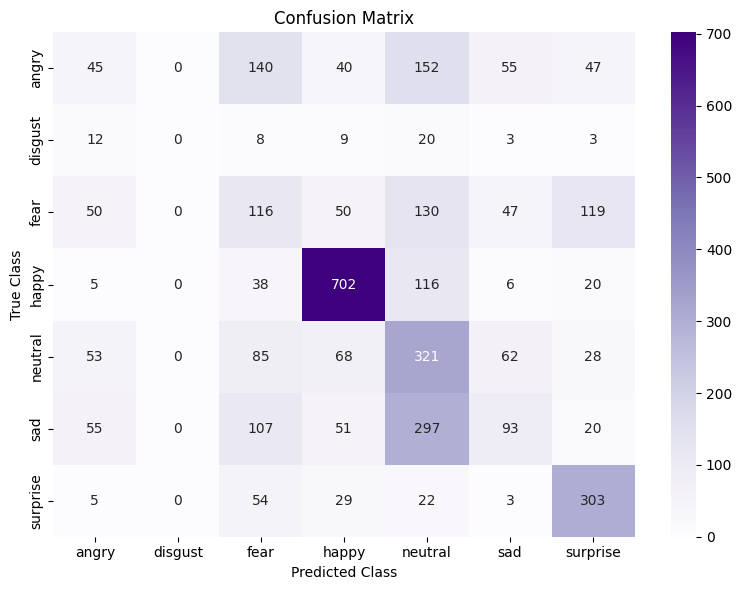

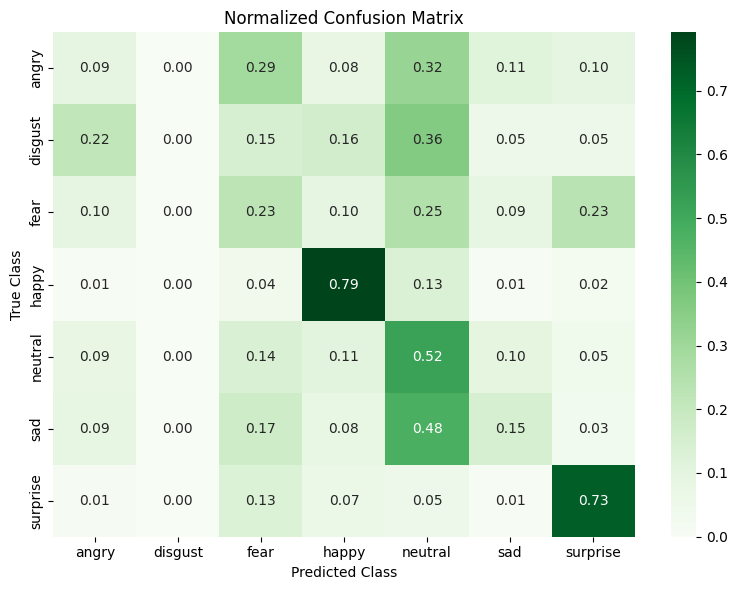

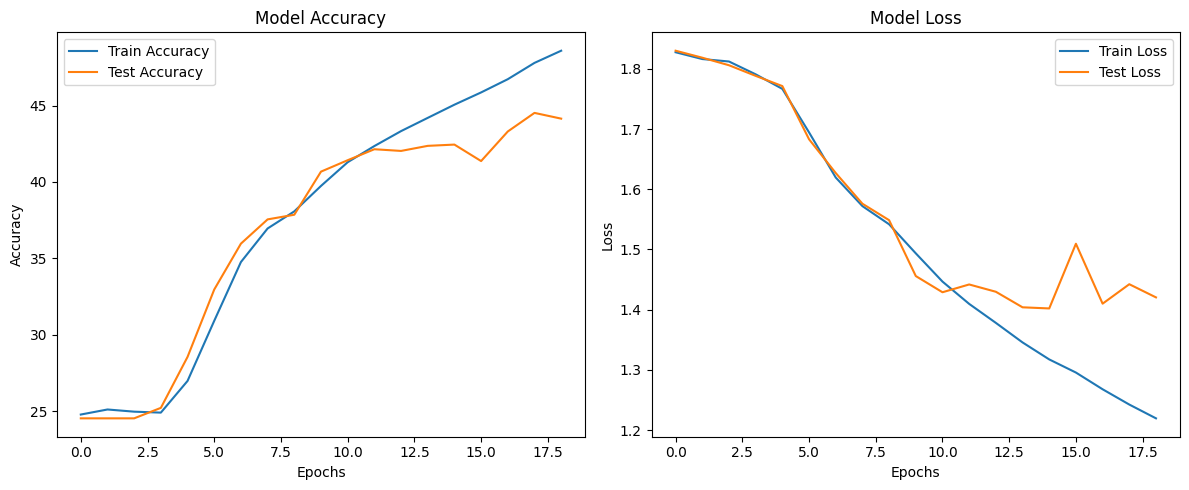


Macro AUC Score (OvR): 0.6082


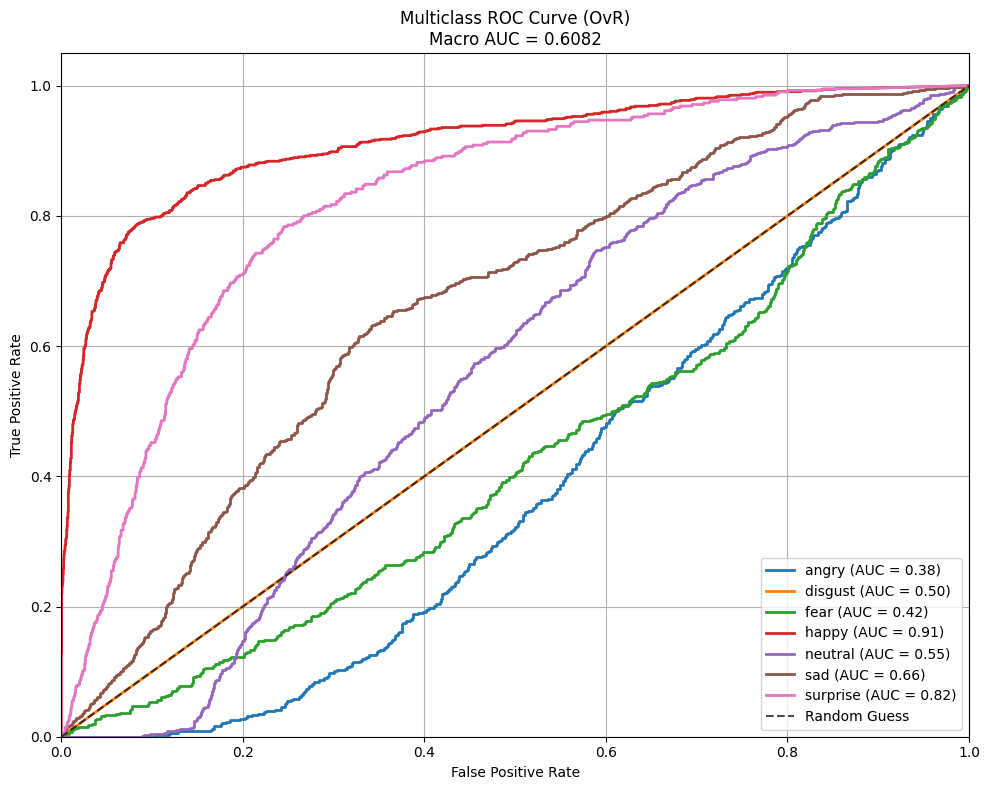

In [14]:
## Testing model

evaluate_model(model=model,
               device=device,
               history=model_history,
               dataloader=test_dataLoader,
               class_names=list(labelToNum_dict.keys()),
               base_dir=os.path.join(modelBase_path, model_name),
               output_dir_name="evaluation")